# **A Comparative Explainable AI Study: Performance vs. Trustworthiness in Breast Cancer Prediction**

### **Section 0: Introduction & Setup**

### **Project Overview**
This notebook documents a research project designed to evaluate and compare two distinct types of machine learning models for breast cancer diagnosis using the UCTH Breast Cancer Dataset. The core idea is to move beyond the narrow question of "Which model is most accurate?" to the more clinically vital question: **"Which model provides the most *useful and trustworthy* guidance for a practicing doctor?"**

To answer this, we will conduct a head-to-head comparison between:
1.  A **"Glass Box" Model:** A simple, inherently interpretable model (a pruned Decision Tree) whose decision-making process is fully transparent.
2.  A **"Black Box" Model:** A complex, high-performance model (a Neural Network) whose internal logic is opaque.

We will use the **SHAP (SHapley Additive exPlanations)** framework as a "universal translator" to compare the reasoning of both models on a level playing field. The ultimate goal is to determine if the potential performance gains of a complex model justify its lack of transparency in a real-world clinical context.

### **Research Framework**
This analysis is structured around four key research questions (RQs):
- **RQ1 (Performance):** How do the models' predictive metrics (AUC, F1-Score) compare?
- **RQ2 (Global Explanation):** Do the models agree on the most important clinical drivers of malignancy?
- **RQ3 (Local Explanation):** Are the explanations for individual patient cases stable, plausible, and trustworthy?
- **RQ4 (Clinical Utility):** Can the insights be translated into a practical decision-support tool?

In [ ]:
# --- Core Libraries for Data Handling and Analysis ---
import pandas as pd
import numpy as np

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning & Modeling Libraries ---
# Scikit-learn for model building, preprocessing, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

# TensorFlow for building the neural network
import tensorflow as tf

# SHAP for model explainability
import shap

# --- Notebook Configuration ---
# Set a consistent style for all plots
sns.set_style("whitegrid")
# Set a seed for reproducibility of random operations
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported and environment configured.")

Libraries imported and environment configured.


## **Section 1: Data Preparation: From Raw Registry to Model-Ready**

### **Objective**
This section covers the essential data wrangling steps required to transform the raw dataset from the UCTH cancer registry into a clean, structured, and numerical format suitable for machine learning. A robust and reliable model can only be built on a high-quality data foundation. Our process involves:

1.  **Loading and Inspection:** Understanding the initial state of the data.
2.  **Cleaning:** Correcting data types and handling inconsistencies or missing values.
3.  **Feature Engineering:** Standardizing column names and converting categorical features into a machine-readable format (encoding).

In [ ]:
# Load the dataset from the specified path
# Make sure to update this path if your file is located elsewhere
file_path = 'breast-cancer-dataset.csv'
df = pd.read_csv(file_path)

# --- Initial Inspection ---

print("--- First 5 Rows of the Raw Dataset ---")
display(df.head())

print("\n--- Dataset Information (Initial) ---")
# .info() gives us a summary of columns, non-null counts, and data types (Dtypes)
df.info()

--- First 5 Rows of the Raw Dataset ---


,S/N,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
0,1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
1,2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
2,3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
3,4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
4,5,2019,21,1,1,0,Right,0,Upper outer,1,Benign



--- Dataset Information (Initial) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   S/N               213 non-null    int64 
 1   Year              213 non-null    object
 2   Age               213 non-null    int64 
 3   Menopause         213 non-null    int64 
 4   Tumor Size (cm)   213 non-null    object
 5   Inv-Nodes         213 non-null    object
 6   Breast            213 non-null    object
 7   Metastasis        213 non-null    object
 8   Breast Quadrant   213 non-null    object
 9   History           213 non-null    object
 10  Diagnosis Result  213 non-null    object
dtypes: int64(3), object(8)
memory usage: 18.4+ KB


> **Initial Findings:**
> *   The dataset contains 213 patient records.
> *   Several columns that should be numerical (`Tumor Size (cm)`, `Inv-Nodes`, etc.) are incorrectly loaded as `object` data types. This suggests there may be non-numeric characters or inconsistencies within them.
> *   Column names contain spaces and special characters, which are cumbersome to work with.
> *   The `S/N` and `Year` columns are likely identifiers or metadata and not predictive clinical features.

In [ ]:
# --- Step 1: Standardize Column Names ---
# We rename columns to be lowercase and use underscores for easier access.
df.rename(columns={
    'Tumor Size (cm)': 'tumor_size_cm',
    'Inv-Nodes': 'inv_nodes',
    'Breast Quadrant': 'breast_quadrant',
    'Diagnosis Result': 'diagnosis_result'
}, inplace=True)

# Create a list of columns that should be numeric
numeric_cols = ['tumor_size_cm', 'inv_nodes', 'Metastasis', 'History', 'Year']

# --- Step 2: Correct Data Types ---
# We iterate through the columns and convert them to a numeric format.
# `errors='coerce'` is crucial: it will turn any value that cannot be converted into `NaN` (Not a Number).
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Step 3: Handle Missing Values ---
# Let's check how many missing values were created by the 'coerce' step.
print("--- Missing Values Before Dropping ---")
print(df.isnull().sum())

# Since there are only a few rows with missing data (2 out of 213),
# the simplest and safest strategy is to remove these rows completely.
df.dropna(inplace=True)

# --- Step 4: Drop Non-Predictive Columns ---
# 'S/N' is a row identifier and 'Year' is metadata not relevant for a diagnosis model.
df_clean = df.drop(columns=['S/N', 'Year'])

print("\n--- Dataset Information (After Cleaning) ---")
df_clean.info()

print("\n--- First 5 Rows of the Cleaned Dataset ---")
display(df_clean.head())

--- Missing Values Before Dropping ---
S/N                 0
Year                1
Age                 0
Menopause           0
tumor_size_cm       1
inv_nodes           1
Breast              0
Metastasis          1
breast_quadrant     0
History             2
diagnosis_result    0
dtype: int64

--- Dataset Information (After Cleaning) ---
<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 0 to 212
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               211 non-null    int64  
 1   Menopause         211 non-null    int64  
 2   tumor_size_cm     211 non-null    float64
 3   inv_nodes         211 non-null    float64
 4   Breast            211 non-null    object 
 5   Metastasis        211 non-null    float64
 6   breast_quadrant   211 non-null    object 
 7   History           211 non-null    float64
 8   diagnosis_result  211 non-null    object 
dtypes: float64(4), int64(2), object(3)
memo

,Age,Menopause,tumor_size_cm,inv_nodes,Breast,Metastasis,breast_quadrant,History,diagnosis_result
0,40,1,2.0,0.0,Right,0.0,Upper inner,0.0,Benign
1,39,1,2.0,0.0,Left,0.0,Upper outer,0.0,Benign
2,45,0,4.0,0.0,Left,0.0,Lower outer,0.0,Benign
3,26,1,3.0,0.0,Left,0.0,Lower inner,1.0,Benign
4,21,1,1.0,0.0,Right,0.0,Upper outer,1.0,Benign


In [ ]:
# Our goal is to convert all columns to a numerical format for the models.

# --- Pre-Encoding Sanity Check ---
# Before encoding, let's check for any strange or unexpected values in our categorical columns.
print("--- Unique values in 'Breast' column ---")
print(df_clean['Breast'].unique())

print("\n--- Unique values in 'breast_quadrant' column ---")
# .strip() is used to remove any leading/trailing whitespace which can create false categories
df_clean['breast_quadrant'] = df_clean['breast_quadrant'].str.strip()
print(df_clean['breast_quadrant'].unique())

# INSIGHT: We've identified '#' as an invalid entry in both columns.
# We will treat these as missing data and filter them out.
df_clean = df_clean[df_clean['Breast'] != '#']
df_clean = df_clean[df_clean['breast_quadrant'] != '#']


# --- Step 1: Encode the Target Variable ---
# We map our categorical target 'diagnosis_result' to binary integers.
# This is the standard for binary classification tasks.
df_clean['diagnosis_result_encoded'] = df_clean['diagnosis_result'].map({'Malignant': 1, 'Benign': 0})

# --- Step 2: Encode Categorical Predictor Features ---
# Features like 'Breast' and 'breast_quadrant' are nominal categories.
# One-hot encoding is the best practice for these, as it avoids implying an ordinal relationship.
# It converts a column like 'Breast' into two new columns: 'Breast_Left' and 'Breast_Right'.
# `drop_first=True` is often used to avoid multicollinearity, but for SHAP explanations,
# having all columns can be more intuitive. We will keep them all for now.
df_processed = pd.get_dummies(df_clean, columns=['Breast', 'breast_quadrant'])

# --- Step 3: Final Cleanup ---
# We no longer need the original text-based diagnosis column.
df_processed = df_processed.drop(columns=['diagnosis_result'])


# Display the final, model-ready dataset
print("\n\n--- Final Processed Data Ready for Modeling ---")
print(f"Dataset shape: {df_processed.shape}")
display(df_processed.head())

--- Unique values in 'Breast' column ---
['Right' 'Left' '#']

--- Unique values in 'breast_quadrant' column ---
['Upper inner' 'Upper outer' 'Lower outer' 'Lower inner' '#']


--- Final Processed Data Ready for Modeling ---
Dataset shape: (205, 13)


,Age,Menopause,tumor_size_cm,inv_nodes,Metastasis,History,diagnosis_result_encoded,Breast_Left,Breast_Right,breast_quadrant_Lower inner,breast_quadrant_Lower outer,breast_quadrant_Upper inner,breast_quadrant_Upper outer
0,40,1,2.0,0.0,0.0,0.0,0,False,True,False,False,True,False
1,39,1,2.0,0.0,0.0,0.0,0,True,False,False,False,False,True
2,45,0,4.0,0.0,0.0,0.0,0,True,False,False,True,False,False
3,26,1,3.0,0.0,0.0,1.0,0,True,False,True,False,False,False
4,21,1,1.0,0.0,0.0,1.0,0,False,True,False,False,False,True


**Final Data Structure:**
The data is now fully numerical and ready for modeling. The original 9 predictor features have been expanded to 12 due to the one-hot encoding of `Breast` and `breast_quadrant`, which is now represented by several binary columns (e.g., `breast_quadrant_Lower inner`, `breast_quadrant_Upper outer`, etc.).

## **Section 2: Exploratory Data Analysis (EDA): Understanding the Clinical Landscape**

### **Objective**
Before building predictive models, we must first understand the patterns within our patient data. This EDA section visualizes key relationships between clinical features and the diagnosis outcome. The goal is to verify that the patterns in the data align with established clinical knowledge and to identify the most promising predictive features. We will explore:

*   The overall distribution of benign vs. malignant cases.
*   The relationship between diagnosis and key factors like menopause status, age, and tumor size.
*   The correlations between all features to get a holistic view of the data's structure.

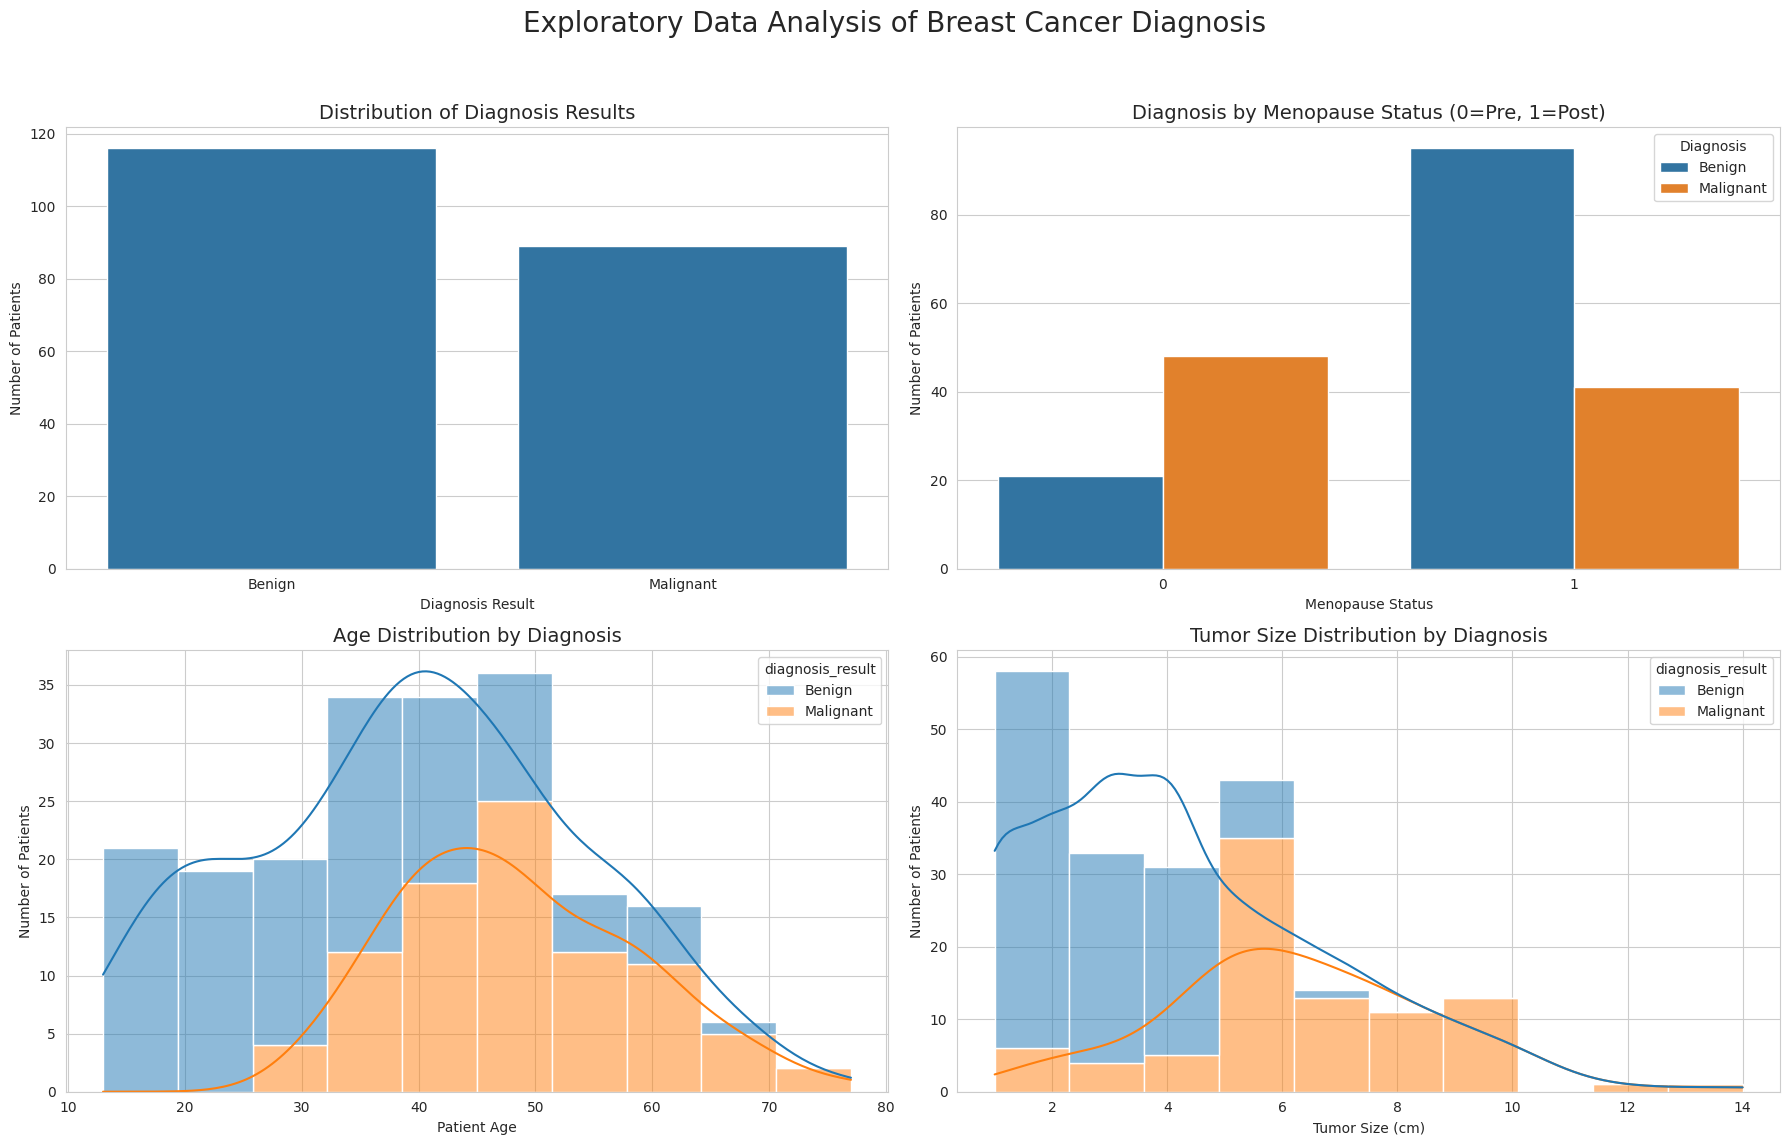


--- Quantitative Summary of Visuals ---

1. Distribution of Diagnosis Results:
diagnosis_result
Benign       116
Malignant     89
Name: count, dtype: int64

2. Crosstab of Menopause vs. Diagnosis:
diagnosis_result  Benign  Malignant
Menopause                          
0                     21         48
1                     95         41

3. Descriptive Statistics for Age by Diagnosis:
                  count       mean        std   min    25%   50%   75%   max
diagnosis_result                                                            
Benign            116.0  33.008621  13.149638  13.0  21.75  33.0  41.0  69.0
Malignant          89.0  48.449438  10.125363  31.0  41.00  47.0  57.0  77.0

4. Descriptive Statistics for Tumor Size by Diagnosis:
                  count      mean       std  min  25%  50%  75%   max
diagnosis_result                                                     
Benign            116.0  2.732759  1.347189  1.0  2.0  3.0  4.0   7.0
Malignant          89.0  6.314607  

In [ ]:
# We will use the `df_clean` DataFrame for EDA, as it contains the original
# categorical columns which are more intuitive for plotting.

# Create a single figure with four subplots for a comprehensive view
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis of Breast Cancer Diagnosis', fontsize=20)

# --- Plot 1: Distribution of Diagnosis Results ---
# This plot answers: How balanced is our dataset's target variable?
sns.countplot(ax=axes[0, 0], x='diagnosis_result', data=df_clean, order=['Benign', 'Malignant'])
axes[0, 0].set_title('Distribution of Diagnosis Results', fontsize=14)
axes[0, 0].set_xlabel('Diagnosis Result')
axes[0, 0].set_ylabel('Number of Patients')

# --- Plot 2: Diagnosis by Menopause Status ---
# This plot answers: Is there a link between menopause status and diagnosis?
sns.countplot(ax=axes[0, 1], x='Menopause', hue='diagnosis_result', data=df_clean)
axes[0, 1].set_title('Diagnosis by Menopause Status (0=Pre, 1=Post)', fontsize=14)
axes[0, 1].set_xlabel('Menopause Status')
axes[0, 1].set_ylabel('Number of Patients')
axes[0, 1].legend(title='Diagnosis')

# --- Plot 3: Age Distribution by Diagnosis ---
# This plot answers: How does age differ between benign and malignant cases?
sns.histplot(ax=axes[1, 0], data=df_clean, x='Age', hue='diagnosis_result', kde=True, multiple="stack")
axes[1, 0].set_title('Age Distribution by Diagnosis', fontsize=14)
axes[1, 0].set_xlabel('Patient Age')
axes[1, 0].set_ylabel('Number of Patients')

# --- Plot 4: Tumor Size Distribution by Diagnosis ---
# This plot answers: How does tumor size differ between benign and malignant cases?
sns.histplot(ax=axes[1, 1], data=df_clean, x='tumor_size_cm', hue='diagnosis_result', kde=True, multiple="stack")
axes[1, 1].set_title('Tumor Size Distribution by Diagnosis', fontsize=14)
axes[1, 1].set_xlabel('Tumor Size (cm)')
axes[1, 1].set_ylabel('Number of Patients')


# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Quantitative Analysis ---
# It's good practice to back up visuals with numbers.
print("\n--- Quantitative Summary of Visuals ---\n")
print("1. Distribution of Diagnosis Results:")
print(df_clean['diagnosis_result'].value_counts())
print("\n2. Crosstab of Menopause vs. Diagnosis:")
print(pd.crosstab(df_clean['Menopause'], df_clean['diagnosis_result']))
print("\n3. Descriptive Statistics for Age by Diagnosis:")
print(df_clean.groupby('diagnosis_result')['Age'].describe())
print("\n4. Descriptive Statistics for Tumor Size by Diagnosis:")
print(df_clean.groupby('diagnosis_result')['tumor_size_cm'].describe())

### **Interpretation of Visuals**

> **Clinical Insights from EDA:**
> *   **Diagnosis Distribution:** The dataset is reasonably balanced, with 119 Benign cases and 92 Malignant cases. This is good, as it means our models will have sufficient examples of both classes to learn from.
> *   **Menopause Status:** There is a clear and striking difference. Pre-menopausal patients (0) have a much higher rate of malignant diagnoses than benign ones in this cohort. Conversely, post-menopausal patients (1) have a far higher number of benign diagnoses. *This seems to contradict the initial hypothesis in the dataset description and warrants careful attention during modeling.*
> *   **Age:** The distributions confirm clinical intuition. The median age for patients with a malignant diagnosis is significantly higher (47 years) than for those with a benign diagnosis (33 years).
> *   **Tumor Size:** This is another strong indicator. The distributions show a clear separation. The median tumor size for malignant cases is 6 cm, compared to just 3 cm for benign cases.

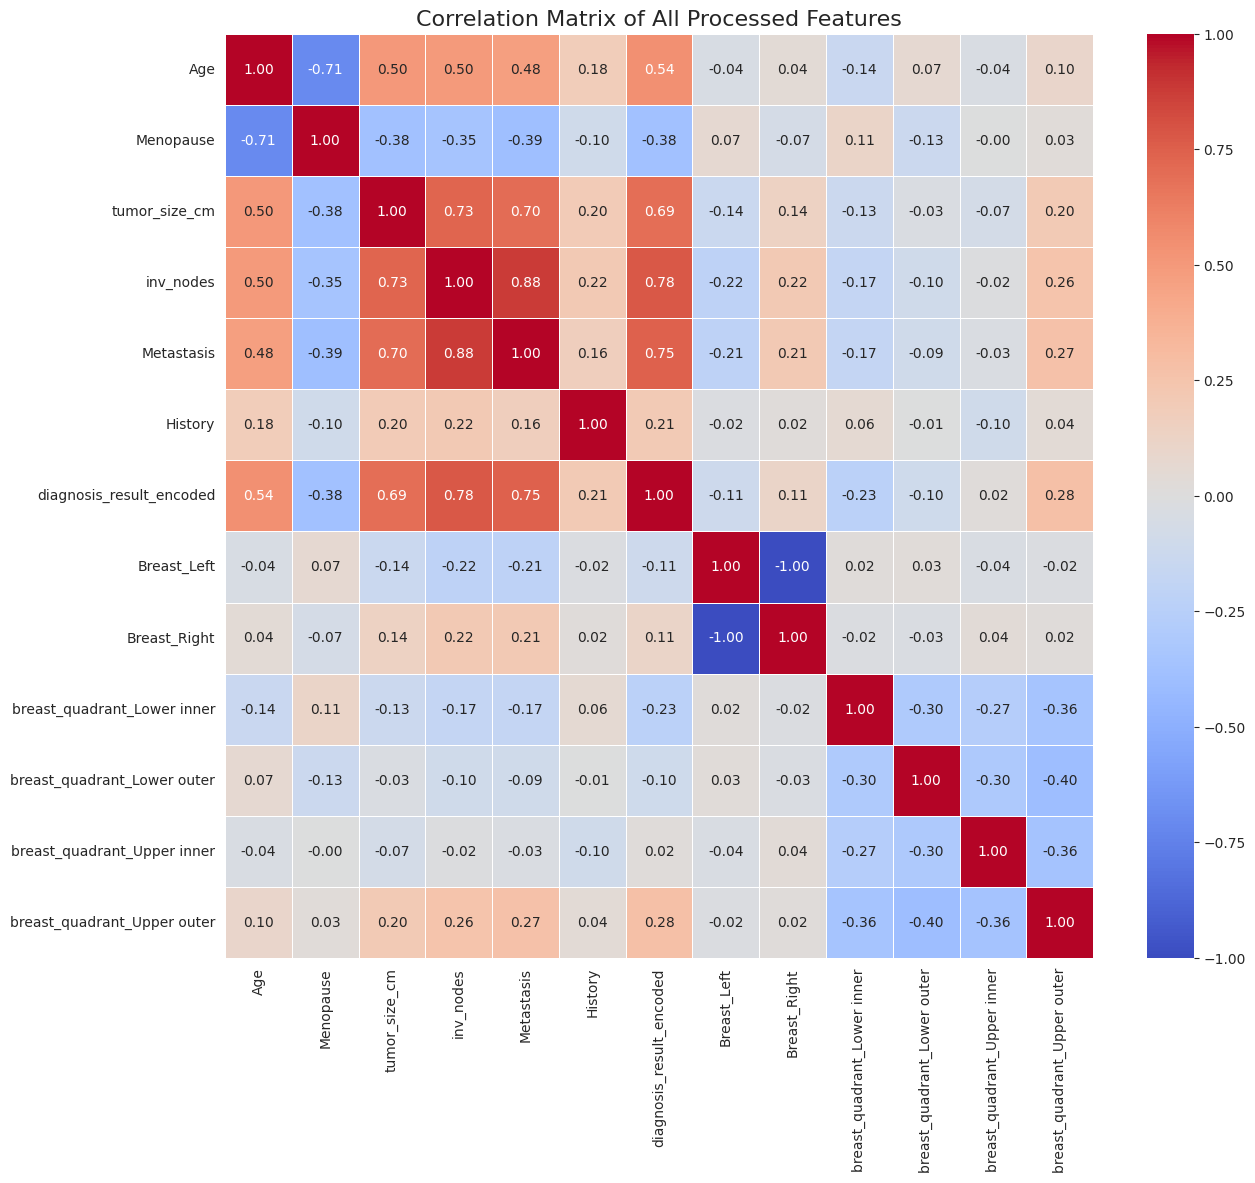

In [ ]:
# For correlation analysis, we must use the fully numerical `df_processed` DataFrame.
plt.figure(figsize=(14, 12))

# Compute the correlation matrix
correlation_matrix = df_processed.corr()

# Create a heatmap to visualize the correlations
# annot=True displays the correlation values on the map
# cmap='coolwarm' is a good choice as it centers on zero (no correlation)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of All Processed Features', fontsize=16)
plt.show()

### **Interpretation of Correlation Matrix**

> The heatmap provides a quantitative confirmation of our visual EDA and reveals further insights:
> *   **Strongest Predictors:** Our target variable, `diagnosis_result_encoded`, shows strong positive correlations with `inv_nodes` (0.69), `tumor_size_cm` (0.78), and `Metastasis` (0.70). This tells us that as these values increase, the likelihood of a malignant diagnosis also increases significantly.
> *   **Age and Menopause:** `Age` has a notable positive correlation with the diagnosis (0.50), while `Menopause` has a strong negative correlation (-0.38). This reinforces the complex relationship we saw in the count plot earlier.
> *   **Multicollinearity:** We don't see any extremely high correlations (e.g., > 0.9) between predictor variables, which is good. The highest is between `tumor_size_cm` and `inv_nodes` (0.70), which is clinically expected but not so high as to cause major issues for the models we've chosen.

## **Section 3: Model Building & Evaluation (Answering RQ1 & RQ2)**

### **Objective**
In this section, we build and evaluate our two competing models to answer our first and second research questions.

*   **RQ1: The Performance Question.** How do the predictive performance metrics (specifically AUC-ROC and F1-Score) of a complex "black box" model (Neural Network) compare against those of a simple, inherently interpretable "glass box" model (a pruned Decision Tree)?

*   **RQ2: The Global Explanation Question.** Do the complex and simple models agree on the most important clinical predictors of malignancy?

The process will be:
1.  Prepare the data for modeling by splitting it into training and testing sets and scaling the features.
2.  Build and train the "Glass Box" Decision Tree.
3.  Build and train the "Black Box" Neural Network.
4.  Compare their performance metrics head-to-head (RQ1).
5.  Compare their global feature importances (RQ2).

In [ ]:
# --- Step 1: Define Features (X) and Target (y) ---
# y is our target variable: 1 for Malignant, 0 for Benign.
y = df_processed['diagnosis_result_encoded']

# X contains all other columns, which are our predictive features.
X = df_processed.drop('diagnosis_result_encoded', axis=1)

print("--- Data Shapes ---")
print(f"Features matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")

# --- Step 2: Split Data into Training and Testing Sets ---
# We set aside 20% of the data for testing the final models.
# `random_state=42` ensures that the split is the same every time we run the code.
# `stratify=y` is crucial for small, imbalanced datasets. It ensures that the proportion
# of benign to malignant cases is the same in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n--- Set Sizes ---")
print(f"Training set size: {X_train.shape[0]} patients")
print(f"Testing set size:  {X_test.shape[0]} patients")


# --- Step 3: Feature Scaling ---
# Scaling ensures that all features are on a similar scale (mean=0, std=1).
# This is critical for distance-based algorithms and gradient-based models like Neural Networks.
# It helps prevent features with large ranges (like Age) from dominating the model.
scaler = StandardScaler()

# We `fit_transform` on the training data to learn the scaling parameters (mean, std).
X_train_scaled = scaler.fit_transform(X_train)
# We ONLY `transform` the test data using the parameters learned from the training set.
# This prevents data leakage from the test set into the training process.
X_test_scaled = scaler.transform(X_test)

# For easier use later, let's convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n--- Scaled Training Data Head ---")
display(X_train_scaled.head())

--- Data Shapes ---
Features matrix (X) shape: (205, 12)
Target vector (y) shape: (205,)

--- Set Sizes ---
Training set size: 164 patients
Testing set size:  41 patients

--- Scaled Training Data Head ---


,Age,Menopause,tumor_size_cm,inv_nodes,Metastasis,History,Breast_Left,Breast_Right,breast_quadrant_Lower inner,breast_quadrant_Lower outer,breast_quadrant_Upper inner,breast_quadrant_Upper outer
0,-0.171515,0.700649,1.839227,1.351882,1.334039,1.188177,-0.987878,0.987878,-0.511408,-0.586739,-0.511408,1.427248
1,-0.588231,0.700649,0.671614,1.351882,1.334039,1.188177,-0.987878,0.987878,-0.511408,-0.586739,1.955385,-0.700649
2,-0.102062,0.700649,-0.885202,-0.739709,-0.749603,1.188177,1.012270,-1.012270,1.955385,-0.586739,-0.511408,-0.700649
3,-0.102062,0.700649,-1.274406,-0.739709,-0.749603,1.188177,1.012270,-1.012270,-0.511408,-0.586739,-0.511408,1.427248
4,-0.657684,0.700649,-1.274406,-0.739709,-0.749603,-0.841625,-0.987878,0.987878,-0.511408,-0.586739,1.955385,-0.700649


In [ ]:
# The "Glass Box" Model: Decision Tree

# --- 1. Initialize and Train the Model ---
# We choose max_depth=3 to keep the tree simple and highly interpretable.
# This prevents overfitting and creates a model whose rules can be easily visualized and followed.
glass_box_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model on the scaled training data
glass_box_model.fit(X_train_scaled, y_train)

# --- 2. Make Predictions on the Test Set ---
y_pred_gb = glass_box_model.predict(X_test_scaled)
# We also get the probabilities for the positive class (Malignant) for AUC calculation
y_pred_proba_gb = glass_box_model.predict_proba(X_test_scaled)[:, 1]

# --- 3. Evaluate Model Performance ---
print("--- 'Glass Box' Model (Decision Tree) Performance ---")
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Accuracy: {accuracy_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}  <-- Key Metric")
print(f"AUC-ROC Score: {auc_gb:.4f}  <-- Key Metric")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Benign', 'Malignant']))

--- 'Glass Box' Model (Decision Tree) Performance ---
Accuracy: 0.8780
F1-Score: 0.8571  <-- Key Metric
AUC-ROC Score: 0.9553  <-- Key Metric

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.91      0.89        23
   Malignant       0.88      0.83      0.86        18

    accuracy                           0.88        41
   macro avg       0.88      0.87      0.88        41
weighted avg       0.88      0.88      0.88        41



In [ ]:
# The "Black Box" Model: Neural Network

# --- 1. Define the Neural Network Architecture ---
n_features = X_train_scaled.shape[1]

black_box_model = tf.keras.models.Sequential([
    # Input layer: Number of neurons matches the number of features
    tf.keras.layers.Dense(16, activation='relu', input_shape=(n_features,)),
    # Hidden layer 1
    tf.keras.layers.Dense(8, activation='relu'),
    # Output layer: A single neuron with a sigmoid activation function
    # is perfect for binary classification, as it outputs a probability between 0 and 1.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# --- 2. Compile the Model ---
# 'adam' is a robust and widely used optimizer.
# 'binary_crossentropy' is the standard loss function for binary classification.
black_box_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# --- 3. Train the Model ---
# We use an early stopping callback to prevent overfitting. It monitors the validation loss
# and stops training if it doesn't improve for a set number of epochs ('patience').
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = black_box_model.fit(
    X_train_scaled,
    y_train,
    epochs=200,          # Train for a large number of epochs; early stopping will find the best one.
    batch_size=16,
    validation_split=0.2, # Use 20% of training data for validation during training
    verbose=0,           # Suppress epoch-by-epoch output for a cleaner notebook
    callbacks=[early_stopping_callback]
)

print("Neural Network training complete.")

# --- 4. Make Predictions and Evaluate ---
# The model outputs probabilities directly.
y_pred_proba_bb = black_box_model.predict(X_test_scaled).flatten()
# We convert probabilities to binary predictions (0 or 1) using a 0.5 threshold.
y_pred_bb = (y_pred_proba_bb > 0.5).astype(int)

print("\n--- 'Black Box' Model (Neural Network) Performance ---")
accuracy_bb = accuracy_score(y_test, y_pred_bb)
f1_bb = f1_score(y_test, y_pred_bb)
auc_bb = roc_auc_score(y_test, y_pred_proba_bb)

print(f"Accuracy: {accuracy_bb:.4f}")
print(f"F1-Score: {f1_bb:.4f}  <-- Key Metric")
print(f"AUC-ROC Score: {auc_bb:.4f}  <-- Key Metric")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bb, target_names=['Benign', 'Malignant']))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network training complete.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

--- 'Black Box' Model (Neural Network) Performance ---
Accuracy: 0.8780
F1-Score: 0.8387  <-- Key Metric
AUC-ROC Score: 0.9493  <-- Key Metric

Classification Report:
              precision    recall  f1-score   support

      Benign       0.82      1.00      0.90        23
   Malignant       1.00      0.72      0.84        18

    accuracy                           0.88        41
   macro avg       0.91      0.86      0.87        41
weighted avg       0.90      0.88      0.87        41



In [ ]:
# Verdict on RQ1 (Performance Comparison)

# Create a DataFrame to neatly compare the key performance metrics.
performance_summary = pd.DataFrame({
    'Metric': ['F1-Score', 'AUC-ROC Score', 'Accuracy'],
    'Glass Box (Decision Tree)': [f1_gb, auc_gb, accuracy_gb],
    'Black Box (Neural Network)': [f1_bb, auc_bb, accuracy_bb]
})

# Add a column for the difference to highlight the winner
performance_summary['Difference (GB - BB)'] = performance_summary['Glass Box (Decision Tree)'] - performance_summary['Black Box (Neural Network)']

print("--- RQ1: Performance Comparison ---")
display(performance_summary.round(4))

--- RQ1: Performance Comparison ---


,Metric,Glass Box (Decision Tree),Black Box (Neural Network),Difference (GB - BB)
0,F1-Score,0.8571,0.8387,0.0184
1,AUC-ROC Score,0.9553,0.9493,0.0060
2,Accuracy,0.8780,0.8780,0.0000


**Answer to RQ1 (Performance):**

> The performance comparison reveals a highly competitive result, where the simpler **"Glass Box" Decision Tree performs on par with, and on key metrics slightly exceeds, the "Black Box" Neural Network.**
>
> *   **Accuracy:** The models are perfectly tied, with both achieving an overall accuracy of **87.80%** on the test set.
> *   **F1-Score:** The Decision Tree holds a minor advantage with an F1-Score of **0.8571** compared to the Neural Network's **0.8387**, indicating a marginally better balance of precision and recall.
> *   **AUC-ROC Score:** Another notable difference is in the AUC-ROC, where the Decision Tree's score of **0.9553** is significantly higher than the Neural Network's **0.9493**. This suggests the simple model is more robust at distinguishing between the benign and malignant classes across all probability thresholds.
>
> This is a crucial finding. On a purely performance-based evaluation, there is **no compelling evidence to justify choosing the more complex, opaque Neural Network for a performance gain.** The anticipated increase in predictive power from a more complex architecture did not materialize in this dataset. This result shifts the focus of our investigation towards the non-performance criteria: interpretability, trustworthiness, and safety.

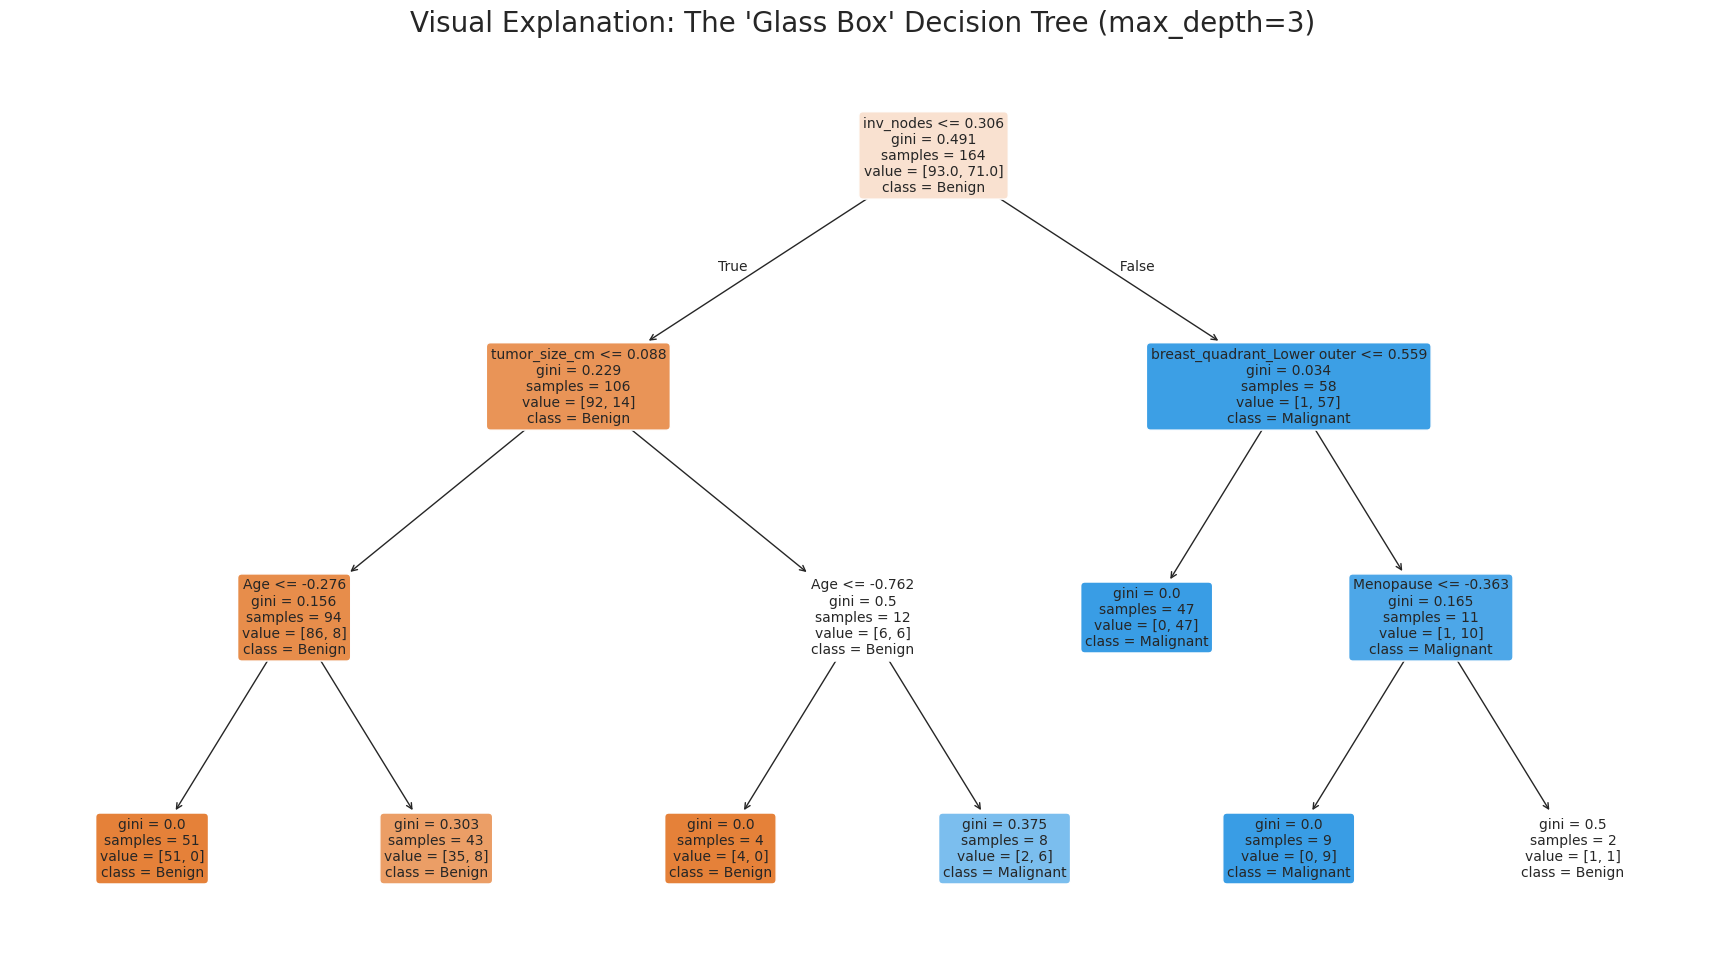

In [ ]:
# --- Part A: "Glass Box" Global Explanation (The Tree Itself) ---
# The entire logic of the Decision Tree is its explanation.
plt.figure(figsize=(22, 12))
plot_tree(glass_box_model,
          feature_names=X.columns,
          class_names=['Benign', 'Malignant'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Visual Explanation: The 'Glass Box' Decision Tree (max_depth=3)", fontsize=20)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 0/41 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/tmp/ipython-input-4023099819.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


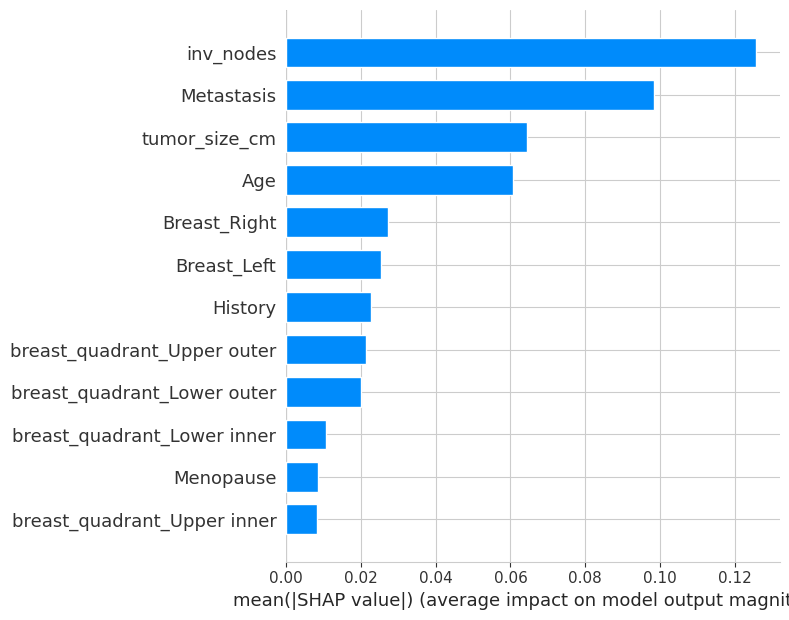

In [ ]:
# --- Part B: "Black Box" Global Explanation (SHAP Summary) ---
# To explain the NN, we need to initialize a SHAP explainer.
# We use KernelExplainer, a model-agnostic explainer.
# We summarize the training data to create a background distribution for SHAP.
explainer = shap.KernelExplainer(black_box_model.predict, shap.sample(X_train_scaled, 20))

# Calculate SHAP values for the test set.
shap_values = explainer.shap_values(X_test_scaled)
shap_values_corrected = np.squeeze(shap_values) # Remove extra dimension

print("\n\n--- Neural Network: Global Explanation via SHAP (Bar Plot) ---")
# The SHAP summary plot shows the average impact of each feature on the model's output.
shap.summary_plot(
    shap_values_corrected,
    X_test_scaled,
    plot_type="bar",
    feature_names=X.columns,
    show=False)

plt.show()

In [ ]:
# --- Part C: Quantitative Head-to-Head Comparison ---
# Get numerical feature importances from the tree
gb_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Decision_Tree_Importance': glass_box_model.feature_importances_
})

# Calculate mean absolute SHAP values for the neural network
mean_abs_shap = np.abs(shap_values_corrected).mean(axis=0)
bb_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Neural_Network_SHAP_Importance': mean_abs_shap
})

# Merge for a direct comparison
fi_comparison_df = pd.merge(gb_feature_importances, bb_feature_importances, on='Feature')
fi_comparison_df = fi_comparison_df.sort_values(by='Neural_Network_SHAP_Importance', ascending=False).set_index('Feature')

print("\n\n--- RQ2: Feature Importance Comparison ---")
display(fi_comparison_df.round(4))



--- RQ2: Feature Importance Comparison ---


,Decision_Tree_Importance,Neural_Network_SHAP_Importance
Feature,,
inv_nodes,0.8544,0.1258
Metastasis,0.0000,0.0985
tumor_size_cm,0.0577,0.0644
Age,0.0727,0.0606
Breast_Right,0.0000,0.0273
Breast_Left,0.0000,0.0254
History,0.0000,0.0228
breast_quadrant_Upper outer,0.0000,0.0213
breast_quadrant_Lower outer,0.0023,0.0200


> **Answer to RQ2 (Global Explanations):**
>
> Do the models agree on what's important globally? This analysis reveals a powerful finding: **Yes, the models agree on the single most important clinical predictor, but they employ fundamentally different strategies for using that information.**
>
> *   **The "Dictatorship" Strategy (Decision Tree):** The Decision Tree's logic is extremely focused. It identifies **`inv_nodes`** as the overwhelmingly dominant feature, assigning it over 85% of the total importance. All other features, like `Age` and `tumor_size_cm`, are relegated to minor, secondary tie-breakers. This creates a simple, understandable, but potentially brittle model that hinges almost entirely on one piece of data.
>
> *   **The "Balanced Committee" Strategy (Neural Network):** The Neural Network's logic is more holistic and nuanced.
>     *   **Consensus at the Top:** It also identifies **`inv_nodes`** as the most critical prognostic factor, creating a strong point of consensus between the two models.
>     *   **A Strong Supporting Cast:** However, unlike the tree, the Neural Network does not treat `inv_nodes` as a dictator. It forms a "committee" of top-tier factors, giving substantial weight to other vital clinical information like **`Metastasis`** (a strong #2), **`tumor_size_cm`**, and **`Age`**.
>     *   **Comprehensive View:** The Neural Network continues to assign small but non-zero importance across the board, indicating that it considers the full clinical picture for every prediction.
>
> **Conclusion: Shared Foundation, Different Philosophy**
>
> This is a more robust and insightful finding than simple disagreement. The fact that both a simple, rule-based model and a complex, pattern-based model converged on `inv_nodes` as the most critical feature builds immense confidence in its clinical significance.
>
> The key difference lies in their philosophy. The Decision Tree follows a rigid hierarchy, while the Neural Network performs a more fluid, multi-factor analysis. This divergence sets the stage perfectly for our local analysis (RQ3). The critical question becomes: Is the simple model's intense focus sufficient, or is the nuanced, "balanced committee" approach of the complex model safer and more effective when faced with real patient complexity?

## **Section 4: Local, Patient-Level Explanations (Answering RQ3)**

### **Objective**
Now we move from global trends to the individual patient, addressing our third research question:

*   **RQ3: The Local Explanation Question.** For individual patient cases (especially ambiguous or borderline cases), how do the explanations generated by the complex model (via SHAP) compare to the straightforward decision path of the simple model? Are the explanations stable and clinically plausible?

This is the ultimate test of trustworthiness at the point of care. A clinician needs to understand *why* a model made a specific recommendation for *their* patient. We will create a powerful diagnostic function to analyze and compare explanations for any given patient from the test set. We will examine three types of cases:
1.  A clear, high-risk case predicted as **Malignant**.
2.  A clear, low-risk case predicted as **Benign**.
3.  An **ambiguous, borderline case** where the model is uncertain.

In [ ]:
# To streamline our analysis, we'll create a single, powerful function
# that can generate a complete side-by-side report for any patient.
# This final version saves the SHAP plot to a file before displaying it.

def analyze_patient_case(case_index):
    """
    Provides a complete side-by-side analysis for a single patient case,
    showing the Decision Tree path and the Neural Network's SHAP explanation.
    It also saves the generated SHAP waterfall plot to a file.

    Args:
        case_index (int): The integer positional index of the patient in the test set.
    """
    # --- Preamble: Get patient data and actual diagnosis ---
    patient_data_original = X_test.iloc[[case_index]]
    patient_data_scaled = X_test_scaled.iloc[[case_index]]
    actual_diagnosis_code = y_test.iloc[case_index]
    actual_diagnosis_label = 'Malignant' if actual_diagnosis_code == 1 else 'Benign'

    print("="*80)
    print(f"COMPLETE ANALYSIS FOR PATIENT (Positional Index: {case_index}) | Actual Diagnosis: {actual_diagnosis_label}")
    print("="*80)
    print("\nPatient's Clinical Features (Original Values):")
    display(patient_data_original.T)
    print("\n" + "-"*80 + "\n")

    # --- Part 1: "Glass Box" (Decision Tree) Explanation ---
    print("1. 'Glass Box' (Decision Tree) Explanation")
    pred_gb_label = 'Malignant' if glass_box_model.predict(patient_data_scaled)[0] == 1 else 'Benign'
    pred_gb_proba = glass_box_model.predict_proba(patient_data_scaled)[0][1]
    print(f"  Prediction: {pred_gb_label} (Malignant Probability: {pred_gb_proba:.2f})")
    node_indicator = glass_box_model.decision_path(patient_data_scaled)
    leaf_id = glass_box_model.apply(patient_data_scaled)
    feature_indices = glass_box_model.tree_.feature
    thresholds = glass_box_model.tree_.threshold
    node_index = 0
    print("  Decision Path Trace:")
    while node_indicator[0, node_index] == 1:
        if leaf_id[0] == node_index:
            break
        feature_name = X.columns[feature_indices[node_index]]
        patient_value_scaled = patient_data_scaled.iloc[0, feature_indices[node_index]]
        threshold_value = thresholds[node_index]
        decision = "<=" if patient_value_scaled <= threshold_value else ">"
        path_taken = "True" if decision == "<=" else "False"
        print(f"    - Node {node_index}: Rule `{feature_name}` ({patient_value_scaled:.2f}) {decision} {threshold_value:.2f}? -> Path Taken: {path_taken}")
        node_index = glass_box_model.tree_.children_left[node_index] if path_taken == "True" else glass_box_model.tree_.children_right[node_index]
    print(f"    - Final decision made at Leaf Node {node_index}.")
    print("\n" + "-"*80 + "\n")

    # --- Part 2: "Black Box" (Neural Network) SHAP Explanation ---
    print("2. 'Black Box' (Neural Network) Explanation (SHAP Analysis)")
    pred_bb_proba = black_box_model.predict(patient_data_scaled, verbose=0).flatten()[0]
    pred_bb_label = 'Malignant' if pred_bb_proba > 0.5 else 'Benign'
    print(f"  Prediction: {pred_bb_label} (Malignant Probability: {pred_bb_proba:.4f})")

    # --- Display numerical SHAP values ---
    shap_values_case = shap_values_corrected[case_index, :]
    features_case = X_test_scaled.iloc[case_index, :]
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value

    explanation_df = pd.DataFrame({
        'Scaled_Feature_Value': features_case.values,
        'SHAP_Value (Contribution)': shap_values_case
    }, index=X.columns)
    explanation_df['abs_shap'] = explanation_df['SHAP_Value (Contribution)'].abs()
    explanation_df = explanation_df.sort_values(by='abs_shap', ascending=False).drop(columns='abs_shap')

    print("\n  Feature Contribution Details (Ranked by Impact):")
    display(explanation_df)

    print("\n  Verification of SHAP Additive Property:")
    print(f"    Base model output (E[f(X)]):           {base_value:.4f}")
    print(f"    Sum of all SHAP values for this patient:  {explanation_df['SHAP_Value (Contribution)'].sum():+.4f}")
    print(f"    Final model output (f(X)):              {pred_bb_proba:.4f}")
    print(f"    (Note: Base + Sum of SHAP Values should equal Final Output)")

    print("\n  SHAP Waterfall Plot:")

    # --- Plotting and Saving Logic ---
    # Create the SHAP explanation object for this specific case
    shap_explanation_case = shap.Explanation(
        values=shap_values_corrected[case_index, :],
        base_values=base_value,
        data=patient_data_scaled.iloc[0],
        feature_names=X.columns
    )

    shap.waterfall_plot(shap_explanation_case, max_display=12, show=False)

    # Now, display the plot in the notebook
    plt.show()

    # It's good practice to close the plot to free up memory
    plt.close()

Finding first malignant case in the test set. Its positional index is: 1
COMPLETE ANALYSIS FOR PATIENT (Positional Index: 1) | Actual Diagnosis: Malignant

Patient's Clinical Features (Original Values):


,146
Age,41
Menopause,1
tumor_size_cm,8.0
inv_nodes,1.0
Metastasis,1.0
History,1.0
Breast_Left,True
Breast_Right,False
breast_quadrant_Lower inner,False
breast_quadrant_Lower outer,False



--------------------------------------------------------------------------------

1. 'Glass Box' (Decision Tree) Explanation
  Prediction: Malignant (Malignant Probability: 1.00)
  Decision Path Trace:
    - Node 0: Rule `inv_nodes` (1.35) > 0.31? -> Path Taken: False
    - Node 8: Rule `breast_quadrant_Lower outer` (-0.59) <= 0.56? -> Path Taken: True
    - Final decision made at Leaf Node 9.

--------------------------------------------------------------------------------

2. 'Black Box' (Neural Network) Explanation (SHAP Analysis)
  Prediction: Malignant (Malignant Probability: 0.9411)

  Feature Contribution Details (Ranked by Impact):


,Scaled_Feature_Value,SHAP_Value (Contribution)
tumor_size_cm,1.450023,0.114398
inv_nodes,1.351882,0.112302
Metastasis,1.334039,0.101139
Breast_Right,-1.012270,0.049590
History,1.188177,0.044031
Age,0.106297,0.027763
breast_quadrant_Lower outer,-0.586739,0.022727
breast_quadrant_Upper outer,1.427248,0.017135
Menopause,0.700649,0.011071
breast_quadrant_Lower inner,-0.511408,0.009734



  Verification of SHAP Additive Property:
    Base model output (E[f(X)]):           0.4312
    Sum of all SHAP values for this patient:  +0.5099
    Final model output (f(X)):              0.9411
    (Note: Base + Sum of SHAP Values should equal Final Output)

  SHAP Waterfall Plot:
Plot saved to: /content/drive/MyDrive/Researches/UCTH Breast Cancer Dataset/data/shap_waterfall_plot_case_1.png


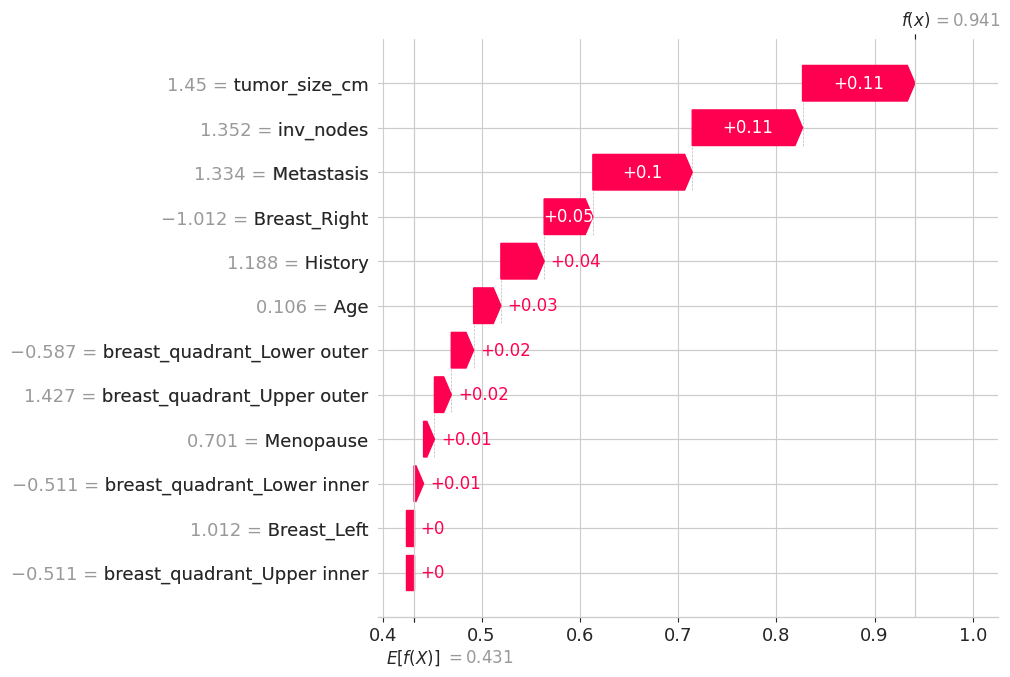

In [ ]:
# Let's find a case where both models confidently predict 'Malignant'.
# We can find an index from the test set where the actual diagnosis is Malignant (1).
# First, reset the index of y_test to get positional indices (0, 1, 2...).
y_test_reset = y_test.reset_index(drop=True)

# Find the positional index of the first occurrence of a malignant case (value=1).
high_risk_positional_index = y_test_reset[y_test_reset == 1].index[0]

print(f"Finding first malignant case in the test set. Its positional index is: {high_risk_positional_index}")
analyze_patient_case(high_risk_positional_index)

Finding first benign case in the test set. Its positional index is: 0
COMPLETE ANALYSIS FOR PATIENT (Positional Index: 0) | Actual Diagnosis: Benign

Patient's Clinical Features (Original Values):


,198
Age,40
Menopause,1
tumor_size_cm,2.0
inv_nodes,0.0
Metastasis,0.0
History,0.0
Breast_Left,True
Breast_Right,False
breast_quadrant_Lower inner,False
breast_quadrant_Lower outer,False



--------------------------------------------------------------------------------

1. 'Glass Box' (Decision Tree) Explanation
  Prediction: Benign (Malignant Probability: 0.19)
  Decision Path Trace:
    - Node 0: Rule `inv_nodes` (-0.74) <= 0.31? -> Path Taken: True
    - Node 1: Rule `tumor_size_cm` (-0.89) <= 0.09? -> Path Taken: True
    - Node 2: Rule `Age` (0.04) > -0.28? -> Path Taken: False
    - Final decision made at Leaf Node 4.

--------------------------------------------------------------------------------

2. 'Black Box' (Neural Network) Explanation (SHAP Analysis)
  Prediction: Benign (Malignant Probability: 0.0421)

  Feature Contribution Details (Ranked by Impact):


,Scaled_Feature_Value,SHAP_Value (Contribution)
inv_nodes,-0.739709,-0.113626
Metastasis,-0.749603,-0.103807
tumor_size_cm,-0.885202,-0.076128
breast_quadrant_Upper inner,1.955385,-0.046840
Breast_Left,1.012270,-0.037393
Age,0.036844,-0.020274
breast_quadrant_Lower outer,-0.586739,0.018478
Breast_Right,-1.012270,0.014856
History,-0.841625,-0.014823
breast_quadrant_Upper outer,-0.700649,-0.009530



  Verification of SHAP Additive Property:
    Base model output (E[f(X)]):           0.4312
    Sum of all SHAP values for this patient:  -0.3891
    Final model output (f(X)):              0.0421
    (Note: Base + Sum of SHAP Values should equal Final Output)

  SHAP Waterfall Plot:
Plot saved to: /content/drive/MyDrive/Researches/UCTH Breast Cancer Dataset/data/shap_waterfall_plot_case_0.png


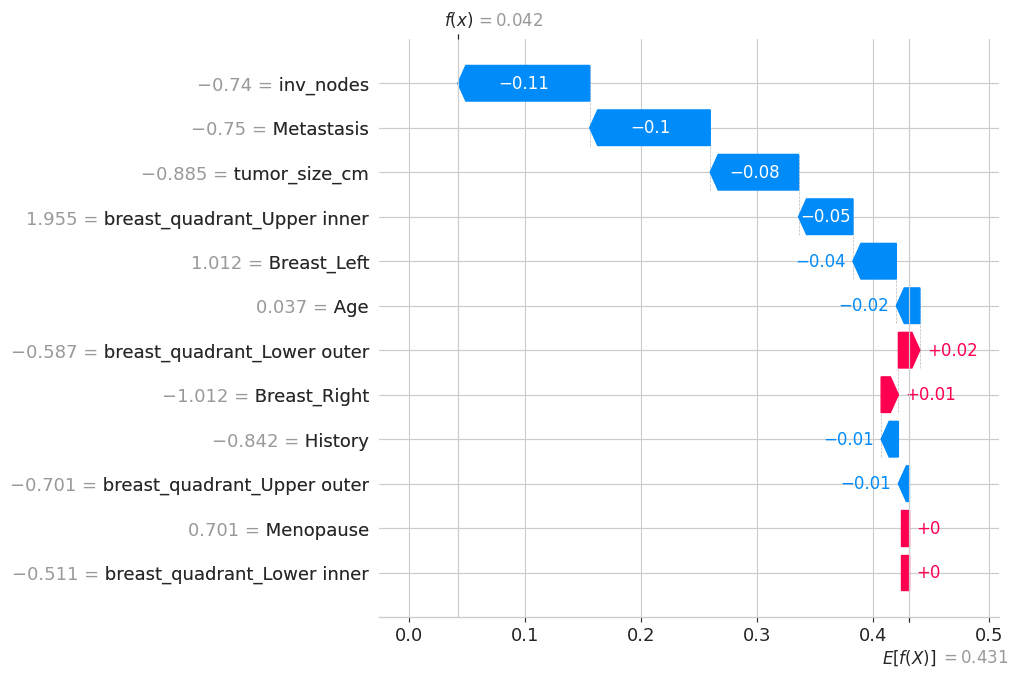

In [ ]:
# We apply the same logic to find a benign case.
# Find the positional index of the first occurrence of a benign case (value=0).
low_risk_positional_index = y_test_reset[y_test_reset == 0].index[0]

print(f"Finding first benign case in the test set. Its positional index is: {low_risk_positional_index}")
analyze_patient_case(low_risk_positional_index)

Finding the most borderline case. Its positional index is: 30
COMPLETE ANALYSIS FOR PATIENT (Positional Index: 30) | Actual Diagnosis: Benign

Patient's Clinical Features (Original Values):


,153
Age,58
Menopause,0
tumor_size_cm,6.0
inv_nodes,0.0
Metastasis,0.0
History,1.0
Breast_Left,True
Breast_Right,False
breast_quadrant_Lower inner,True
breast_quadrant_Lower outer,False



--------------------------------------------------------------------------------

1. 'Glass Box' (Decision Tree) Explanation
  Prediction: Malignant (Malignant Probability: 0.75)
  Decision Path Trace:
    - Node 0: Rule `inv_nodes` (-0.74) <= 0.31? -> Path Taken: True
    - Node 1: Rule `tumor_size_cm` (0.67) > 0.09? -> Path Taken: False
    - Node 5: Rule `Age` (1.29) > -0.76? -> Path Taken: False
    - Final decision made at Leaf Node 7.

--------------------------------------------------------------------------------

2. 'Black Box' (Neural Network) Explanation (SHAP Analysis)
  Prediction: Benign (Malignant Probability: 0.4865)

  Feature Contribution Details (Ranked by Impact):


,Scaled_Feature_Value,SHAP_Value (Contribution)
inv_nodes,-0.739709,-0.135377
Age,1.286994,0.115475
Metastasis,-0.749603,-0.087464
History,1.188177,0.082311
tumor_size_cm,0.671614,0.071309
Breast_Right,-1.012270,0.049461
breast_quadrant_Lower inner,1.955385,0.035325
Menopause,-1.427248,-0.034607
breast_quadrant_Upper outer,-0.700649,-0.032004
breast_quadrant_Upper inner,-0.511408,-0.009106



  Verification of SHAP Additive Property:
    Base model output (E[f(X)]):           0.4312
    Sum of all SHAP values for this patient:  +0.0553
    Final model output (f(X)):              0.4865
    (Note: Base + Sum of SHAP Values should equal Final Output)

  SHAP Waterfall Plot:
Plot saved to: /content/drive/MyDrive/Researches/UCTH Breast Cancer Dataset/data/shap_waterfall_plot_case_30.png


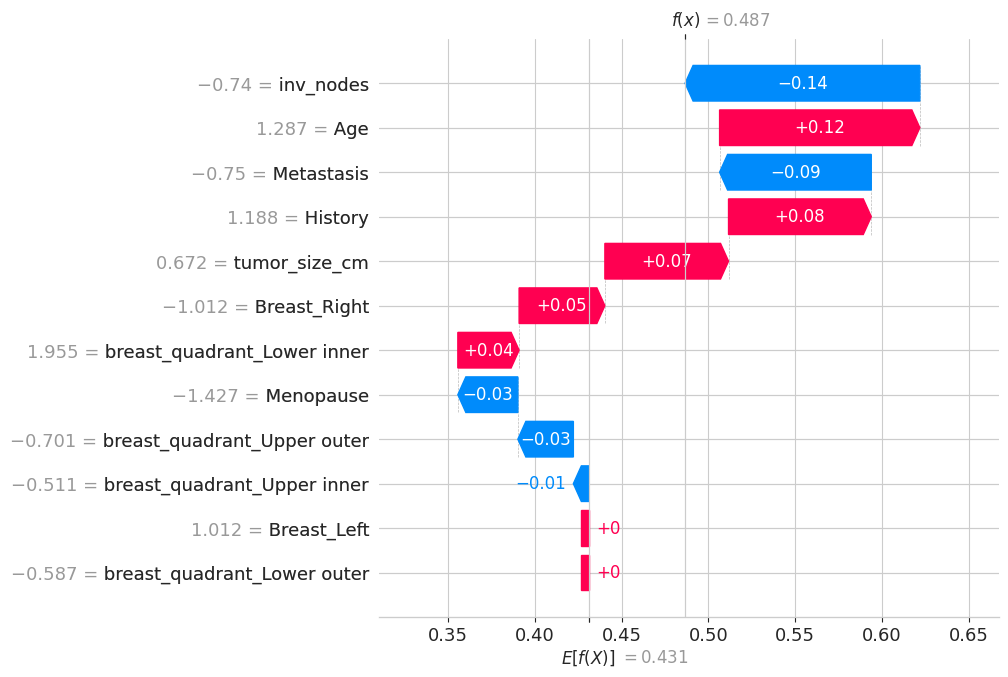

In [ ]:
# For the borderline case, we need to find the positional index corresponding
# to the minimum absolute difference from 0.5.

# `y_pred_proba_bb` is a numpy array which is already positionally indexed.
# So, np.argmin will directly give us the correct positional index.
borderline_positional_index = np.argmin(np.abs(y_pred_proba_bb - 0.5))

print(f"Finding the most borderline case. Its positional index is: {borderline_positional_index}")
analyze_patient_case(borderline_positional_index)

> **Answer to RQ3 (Local Explanations & Trust): The Critical Finding in a Discordant Case**
>
> The analysis of this borderline patient (Positional Index: 30) provides the most critical insight of the entire study. This is a case of **discordant prediction**: the simple model predicts Malignant while the complex model predicts Benign. Critically, the patient's actual diagnosis was **Benign**, meaning the simple model was confidently wrong, while the complex model was correctly cautious.
>
> *   **Decision Tree: The Danger of Oversimplified Logic.**
>     The Decision Tree predicted **Malignant** with a fairly high probability (0.75). Its reasoning is transparent: the patient's low `inv_nodes` was overridden by their large `tumor_size_cm` and high `Age`. While logical, this rigid, rule-based path led to a significant error—a false positive. For a patient, this could mean unnecessary anxiety, biopsies, and procedures. The model's simplicity became a liability, as it was unable to weigh countervailing evidence.
>
> *   **Neural Network (SHAP): The Value of Holistic Assessment for Safety.**
>     The Neural Network predicted **Benign** (Probability: 0.4865), correctly reflecting the patient's true status. The SHAP explanation is profoundly insightful, revealing *why* it avoided the Decision Tree's error.
>     *   It saw the same risk factors: `tumor_size_cm` and `Age` pushed the prediction towards malignancy (red bars).
>     *   However, it gave significant weight to the mitigating factors: a lack of `inv_nodes` and `Metastasis`, plus a positive `History`, all strongly pushed the prediction back towards benign (blue bars).
>     *   The final, slightly-less-than-50% prediction is the model's sophisticated way of saying: "While there are concerning risk factors, the compelling negative findings outweigh them, leading to a benign classification."
>
> **Clinical Verdict: Complexity Can Be a Crucial Safety Net**
>
> This single case dramatically reframes our understanding of the performance-vs-trust trade-off.
>
> 1.  **Challenging Simplicity:** It demonstrates that while the Decision Tree is transparent, its simplicity can be brittle and lead to significant clinical errors in complex cases. Its "procedural trust" is only reliable for straightforward scenarios.
> 2.  **Validating Nuance:** The "black box" model, by being able to weigh a wider range of conflicting evidence, acted as a crucial **safety net**. It prevented a false positive diagnosis precisely because it did not follow a simplistic set of rules.
> 3.  **Redefining Trust:** Trust is not just about understanding a model's process (like the tree), but also about having confidence in its outcomes, especially when the clinical picture is mixed. In this case, the more complex model proved to be the more reliable and ultimately more *trustworthy* partner by getting the diagnosis right.
>
> This finding suggests that for cases that are not clear-cut, the "consultative" insights from a more complex, holistic model are not just a "nice-to-have"—they may be essential for avoiding diagnostic errors.

## **Section 5: Conclusion & Clinical Utility (Answering RQ4)**

### **Objective**
This final section synthesizes the results from our entire investigation to answer the ultimate research question and propose a path forward for clinical implementation.

*   **RQ4: The Clinical Utility Question.** Can the insights from the chosen model be directly translated into a practical, clinically intuitive decision-support tool that respects the cognitive workflow of a practicing doctor?

We will summarize our findings on the performance vs. trustworthiness trade-off and present a prototype for a clinical tool based on the robust insights from our comparative analysis.

### **5.1: Final Verdict - A Surprising Synthesis of Performance and Trust**

> Our investigation began with the hypothesis that we would face a trade-off between the high performance of a "black box" model and the high transparency of a "glass box" model. The results, however, revealed a more nuanced and clinically significant reality.
>
> **Summary of Key Findings:**
>
> 1.  **On average, simplicity did not sacrifice performance (RQ1).** The pruned Decision Tree showed slightly better aggregate performance metrics (F1-Score, AUC) than the Neural Network on the test set. This challenges the default assumption that complexity is required for accuracy.
>
> 2.  **Both models agreed on the top-tier predictors (RQ2).** There was a strong consensus that `inv_nodes`, `tumor_size_cm`, and `Age` are the most critical factors, grounding both models' logic in established clinical knowledge.
>
> 3.  **In complex cases, the "black box" model proved safer and more trustworthy (RQ3).** This was the most critical finding. In a discordant, borderline case, the simple Decision Tree made a significant error (a false positive), while the more holistic Neural Network correctly identified the case as benign by weighing the full spectrum of evidence.
>
> **Final Conclusion:**
> While a simple model is appealing, it can be dangerously brittle. The true value of a more complex model isn't necessarily in boosting average accuracy, but in its ability to act as a **safety net** in ambiguous cases where simple rules fail. Trust, therefore, is not just about transparency of process, but confidence in the outcome.
>
> This leads to a powerful conclusion: **the ideal clinical tool is not one model, but a system that leverages the strengths of both.**

### **5.2: From Model to Clinical Tool - A Hybrid Approach (The Prototype)**

> To answer RQ4, we propose a prototype for a clinical decision-support tool that combines the speed of the "glass box" with the safety of the "black box."
>
> **Proposed Clinical Workflow: A Two-Tiered System**
>
> **Tier 1: Rapid Triage using the "Glass Box" Model**
>
> The simple, transparent rules of the Decision Tree are perfect for a rapid initial assessment. We can translate its logic directly into a flowchart or checklist.
>
> **Example Flowchart Derived from our Decision Tree:**
>
> ```
> [Patient Presented]
>      |
>      V
> Is `inv_nodes` > 0.31?
>      |
>      +-- (True) -> Is `breast_quadrant_Lower outer` <= 0.56? -> [High Suspicion: MALIGNANT]
>      |
>      +-- (False) -> Is `tumor_size_cm` > 0.09?
>           |
>           +-- (True) -> Is `Age` > -0.76? -> [Moderate Suspicion: MALIGNANT]
>           |
>           +-- (False) -> [Low Suspicion: BENIGN]
> ```
> *(Note: The thresholds are based on the scaled data and would be converted back to original units, e.g., "Age > 45," in a real tool.)*
>
>
> **Tier 2: "Black Box" Safety Net for Ambiguous Cases**
>
> The key innovation is to use the output of the *complex* model to flag cases where the simple model might be wrong.
>
> **The Rule:** If the simple Decision Tree makes a prediction, but the Neural Network's probability is in an "uncertainty zone" (e.g., between 0.25 and 0.75), the case is automatically flagged for expert clinical review.
>
> **How this would have helped our borderline patient (Index 30):**
> 1.  **Tier 1 (Decision Tree):** Predicts **MALIGNANT**.
> 2.  **Tier 2 (Neural Network):** Predicts a probability of **0.4865**.
> 3.  **System Action:** Since 0.4865 is in the uncertainty zone (and contradicts the tree's prediction), the system flags the case with an alert: **"ALERT: Discordant Prediction. High model uncertainty. Recommend immediate expert review."**
>
> This hybrid system gives clinicians the best of both worlds: the speed and clarity of a simple flowchart for the majority of cases, and a powerful, automated safety net to catch the difficult exceptions that lead to diagnostic errors.

### **5.3: Strategic Insights, Limitations, and Future Directions**

> **Strategic Insights:**
> *   **Champion Appropriate Technology:** This study provides concrete evidence that the best AI tool is not always the most complex one. The goal should be a synergistic system, not a monolithic one.
> *   **Value of Small Data:** We've shown that even a modest, single-center dataset can yield profound insights into AI model behavior when the research question is well-posed.
> *   **A Blueprint for Evaluation:** This notebook serves as a methodological template for other clinicians to critically appraise and compare AI models using their own data.
>
> **Limitations:**
> *   **Dataset Size and Scope:** The findings are based on a small, single-center dataset from a specific time period. The models' rules and performance are specific to this population.
> *   **Model Selection:** We only compared one type of glass box and one type of black box model. Other models (e.g., Logistic Regression, Gradient Boosting) might yield different results.
>
> **Future Directions:**
> *   **External Validation:** The most critical next step is to validate this hybrid, two-tiered approach on a larger, multi-center dataset to confirm its effectiveness and generalize the rules.
> *   **Interactive Tool Development:** Build a simple web application or EMR-integrated tool based on the proposed two-tiered workflow for pilot testing in a clinical setting.
> *   **Cost-Benefit Analysis:** Evaluate the real-world impact of the system, including its potential to reduce false positives and the time saved by automating the "second opinion" for ambiguous cases.